In [1]:
import torch
from data_utils import dataset_x
from data import Augmentation, SSLImageDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torchvision
from torchvision import transforms

import ffcv
from ffcv_ssl import DivideImageBy255

/home/erlandbo/anaconda3/envs/ffcv-ssl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
basedataset = "cifar10"
use_ffcv = True
batchsize = 4
numworkers = 10

In [3]:
def build_ffcv_sslloader(write_path, imgsize, mean, std, batchsize, numworkers, mode="train"):
    image_pipeline1 = [
        ffcv.fields.rgb_image.RandomResizedCropRGBImageDecoder(output_size=imgsize, scale=(0.2, 1.0)),
        #ffcv.transforms.RandomResizedCrop(output_size=imgsize, scale=(0.2, 1.0), ratio=(0.75, 1.3333333333333333)),
        ffcv.transforms.flip.RandomHorizontalFlip(flip_prob=0.5),
        ffcv.transforms.colorjitter.RandomColorJitter(jitter_prob=0.8, brightness=0.4,contrast=0.4,saturation=0.4,hue=0.1),
        ffcv.transforms.grayscale.RandomGrayscale(gray_prob=0.2),
        ffcv.transforms.ops.ToTensor(),
        #ffcv.transforms.ToDevice(torch.device('cuda:0'), non_blocking=True),
        ffcv.transforms.ops.ToTorchImage(convert_back_int16=False),
        #ffcv.transforms.NormalizeImage(np.array(mean)*255, np.array(std)*255, np.float32),
        DivideImageBy255(torch.float32),
        torchvision.transforms.Normalize(mean, std)
    ]
    image_pipeline2 = [
        ffcv.fields.rgb_image.RandomResizedCropRGBImageDecoder(output_size=imgsize, scale=(0.2, 1.0)),
        # ffcv.transforms.RandomResizedCrop(output_size=imgsize, scale=(0.2, 1.0), ratio=(0.75, 1.3333333333333333)),
        ffcv.transforms.flip.RandomHorizontalFlip(flip_prob=0.5),
        ffcv.transforms.colorjitter.RandomColorJitter(jitter_prob=0.8, brightness=0.4, contrast=0.4, saturation=0.4,hue=0.1),
        ffcv.transforms.grayscale.RandomGrayscale(gray_prob=0.2),
        ffcv.transforms.ops.ToTensor(),
        #ffcv.transforms.ToDevice(torch.device('cuda:0'), non_blocking=True),
        ffcv.transforms.ops.ToTorchImage(convert_back_int16=False),
        #ffcv.transforms.NormalizeImage(np.array(mean)*255, np.array(std)*255, np.float32),
        DivideImageBy255(torch.float32),
        torchvision.transforms.Normalize(mean, std)
    ]

    label_pipeline = [
        ffcv.fields.basics.IntDecoder(),
        ffcv.transforms.ops.ToTensor(),
        ffcv.transforms.common.Squeeze(1)
    ]

    idx_pipeline = [
        ffcv.fields.basics.IntDecoder(),
        ffcv.transforms.ops.ToTensor(),
        ffcv.transforms.common.Squeeze(1)
    ]

    loader = ffcv.loader.Loader(
        write_path,
        num_workers=numworkers,
        batch_size=batchsize,
        pipelines={
            "image": image_pipeline1,
            "image2": image_pipeline2,
            "label": label_pipeline,
            "idx": idx_pipeline,
        },
        # We need this custom mapper to map the additional pipeline to
        # the label used in the dataset (image in this case)
        custom_field_mapper={"image2": "image"},
        order=ffcv.loader.OrderOption.RANDOM if mode=="train" else ffcv.loader.OrderOption.SEQUENTIAL,
        drop_last=False,
        os_cache=True,
        seed=42
    )
    return loader


def build_ffcv_nonsslloader(write_path, imgsize, mean, std, batchsize, numworkers, mode="train"):
    image_pipeline1 = [
        ffcv.fields.rgb_image.SimpleRGBImageDecoder(),
        ffcv.transforms.ops.ToTensor(),
        #ToDevice(torch.device('cuda:0'), non_blocking=True),
        ffcv.transforms.ops.ToTorchImage(convert_back_int16=False),
        DivideImageBy255(torch.float32),
        torchvision.transforms.Normalize(mean, std)
        #ffcv.transforms.normalize.NormalizeImage(mean=np.array(mean)*255.0, std=np.array(std)*255.0, type=np.float32)
    ]

    label_pipeline = [
        ffcv.fields.basics.IntDecoder(),
        ffcv.transforms.ops.ToTensor(),
        ffcv.transforms.common.Squeeze(1),
        #ToDevice(torch.device('cuda:0'), non_blocking=True),  # not int on gpu
    ]

    loader = ffcv.loader.Loader(
        write_path,
        num_workers=numworkers,
        batch_size=batchsize,
        pipelines={
            "image": image_pipeline1,
            "label": label_pipeline,
        },
        order=OrderOption.RANDOM if mode == 'train' else OrderOption.SEQUENTIAL,
        drop_last=False,
        os_cache=True,
        seed=42
    )
    return loader

In [4]:

train_basedataset, test_basedataset, num_classes, imgsize, mean, std = dataset_x(basedataset)

if not use_ffcv:
    train_augmentation = Augmentation(imgsize, mean, std, mode="train", num_views=2)
    train_dataset = SSLImageDataset(train_basedataset, train_augmentation)
    trainloader = DataLoader(train_dataset,batch_size=batchsize,shuffle=False, num_workers=numworkers,pin_memory=True, drop_last=False)
else:
    trainloader = build_ffcv_sslloader(
        write_path=f"output/{basedataset}/ssltrainds.beton",
        mean=mean,
        std=std,
        imgsize=imgsize,
        batchsize=batchsize,
        numworkers=numworkers,
        mode="test"
    )

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
plaindataset = torchvision.datasets.CIFAR10(
        root="./data",
        train=True,
        transform=transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        download=True
    )

vizdataloader = DataLoader(plaindataset, batch_size=batchsize, shuffle=False)


Files already downloaded and verified


In [6]:
len(next(iter(trainloader)))

4

In [7]:
imgs_aug1, y, idx, imgs_aug2 = next(iter(trainloader))
imgs_orig, labels = next(iter(vizdataloader))

In [8]:
y

tensor([6, 9, 9, 4])

In [9]:
labels

tensor([6, 9, 9, 4])

In [10]:

label2name = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

def plot_imgs(imgs_orig, imgs_aug1, imgs_aug2, labels):
    maximg = min(4, imgs_orig.shape[0])
    imgs_orig, imgs_aug1, imgs_aug2, labels = imgs_orig[:maximg], imgs_aug1[:maximg], imgs_aug2[:maximg], labels[:maximg]
    fig, ax = plt.subplots(maximg, 3, figsize=(25, 25))
    for i, (img_orig, img_aug1, img_aug2) in enumerate(zip(imgs_orig, imgs_aug1, imgs_aug2)):
        ax[i, 0].imshow(img_orig.permute(1,2,0) * 0.5 + 0.5)
        ax[i, 1].imshow(img_aug1.permute(1,2,0) * 0.5 + 0.5)
        ax[i, 2].imshow(img_aug2.permute(1,2,0) * 0.5 + 0.5)
        
        ax[i, 0].set_title("Original " + label2name[int(labels[i])], fontsize=16, pad=5)
        ax[i, 1].set_title("Augmented " + label2name[int(labels[i])] + " 1", fontsize=16, pad=5)
        ax[i, 2].set_title("Augmented " + label2name[int(labels[i])] + " 2", fontsize=16, pad=5)
        
    plt.tight_layout()
    fig.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_94866/1493470939.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.s

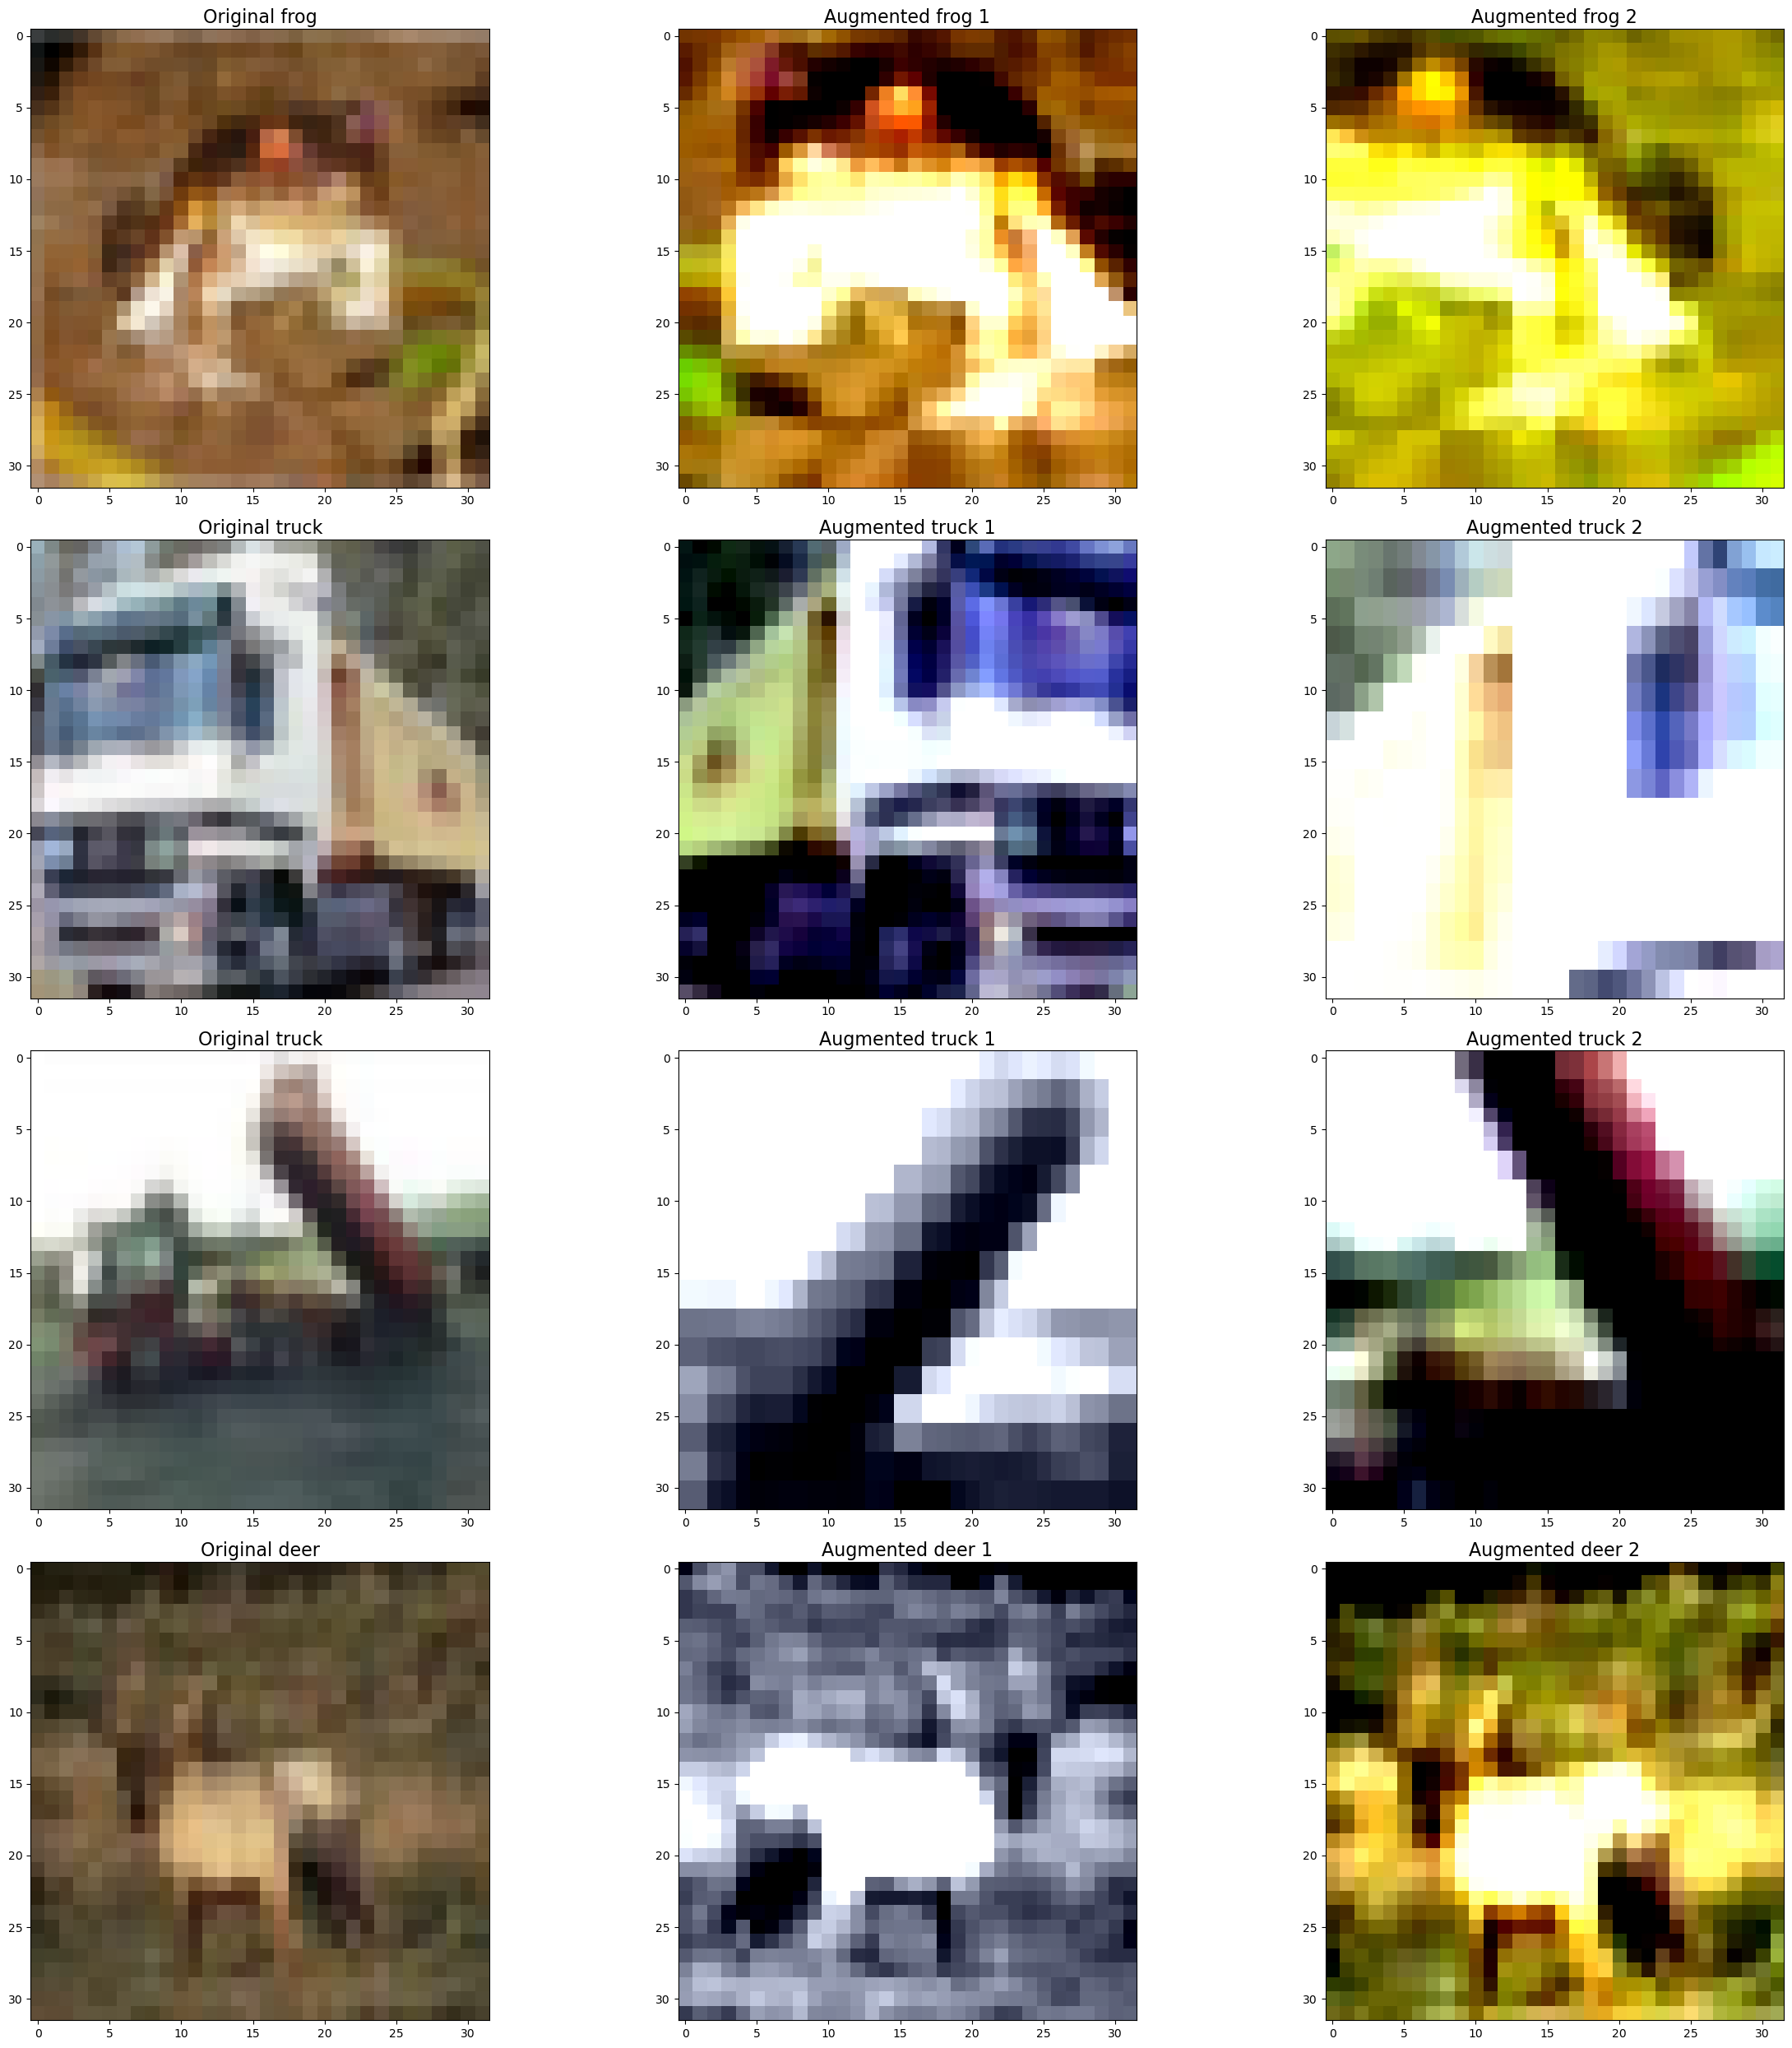

In [11]:
plot_imgs(imgs_orig, imgs_aug1, imgs_aug2, labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_94866/1493470939.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.s

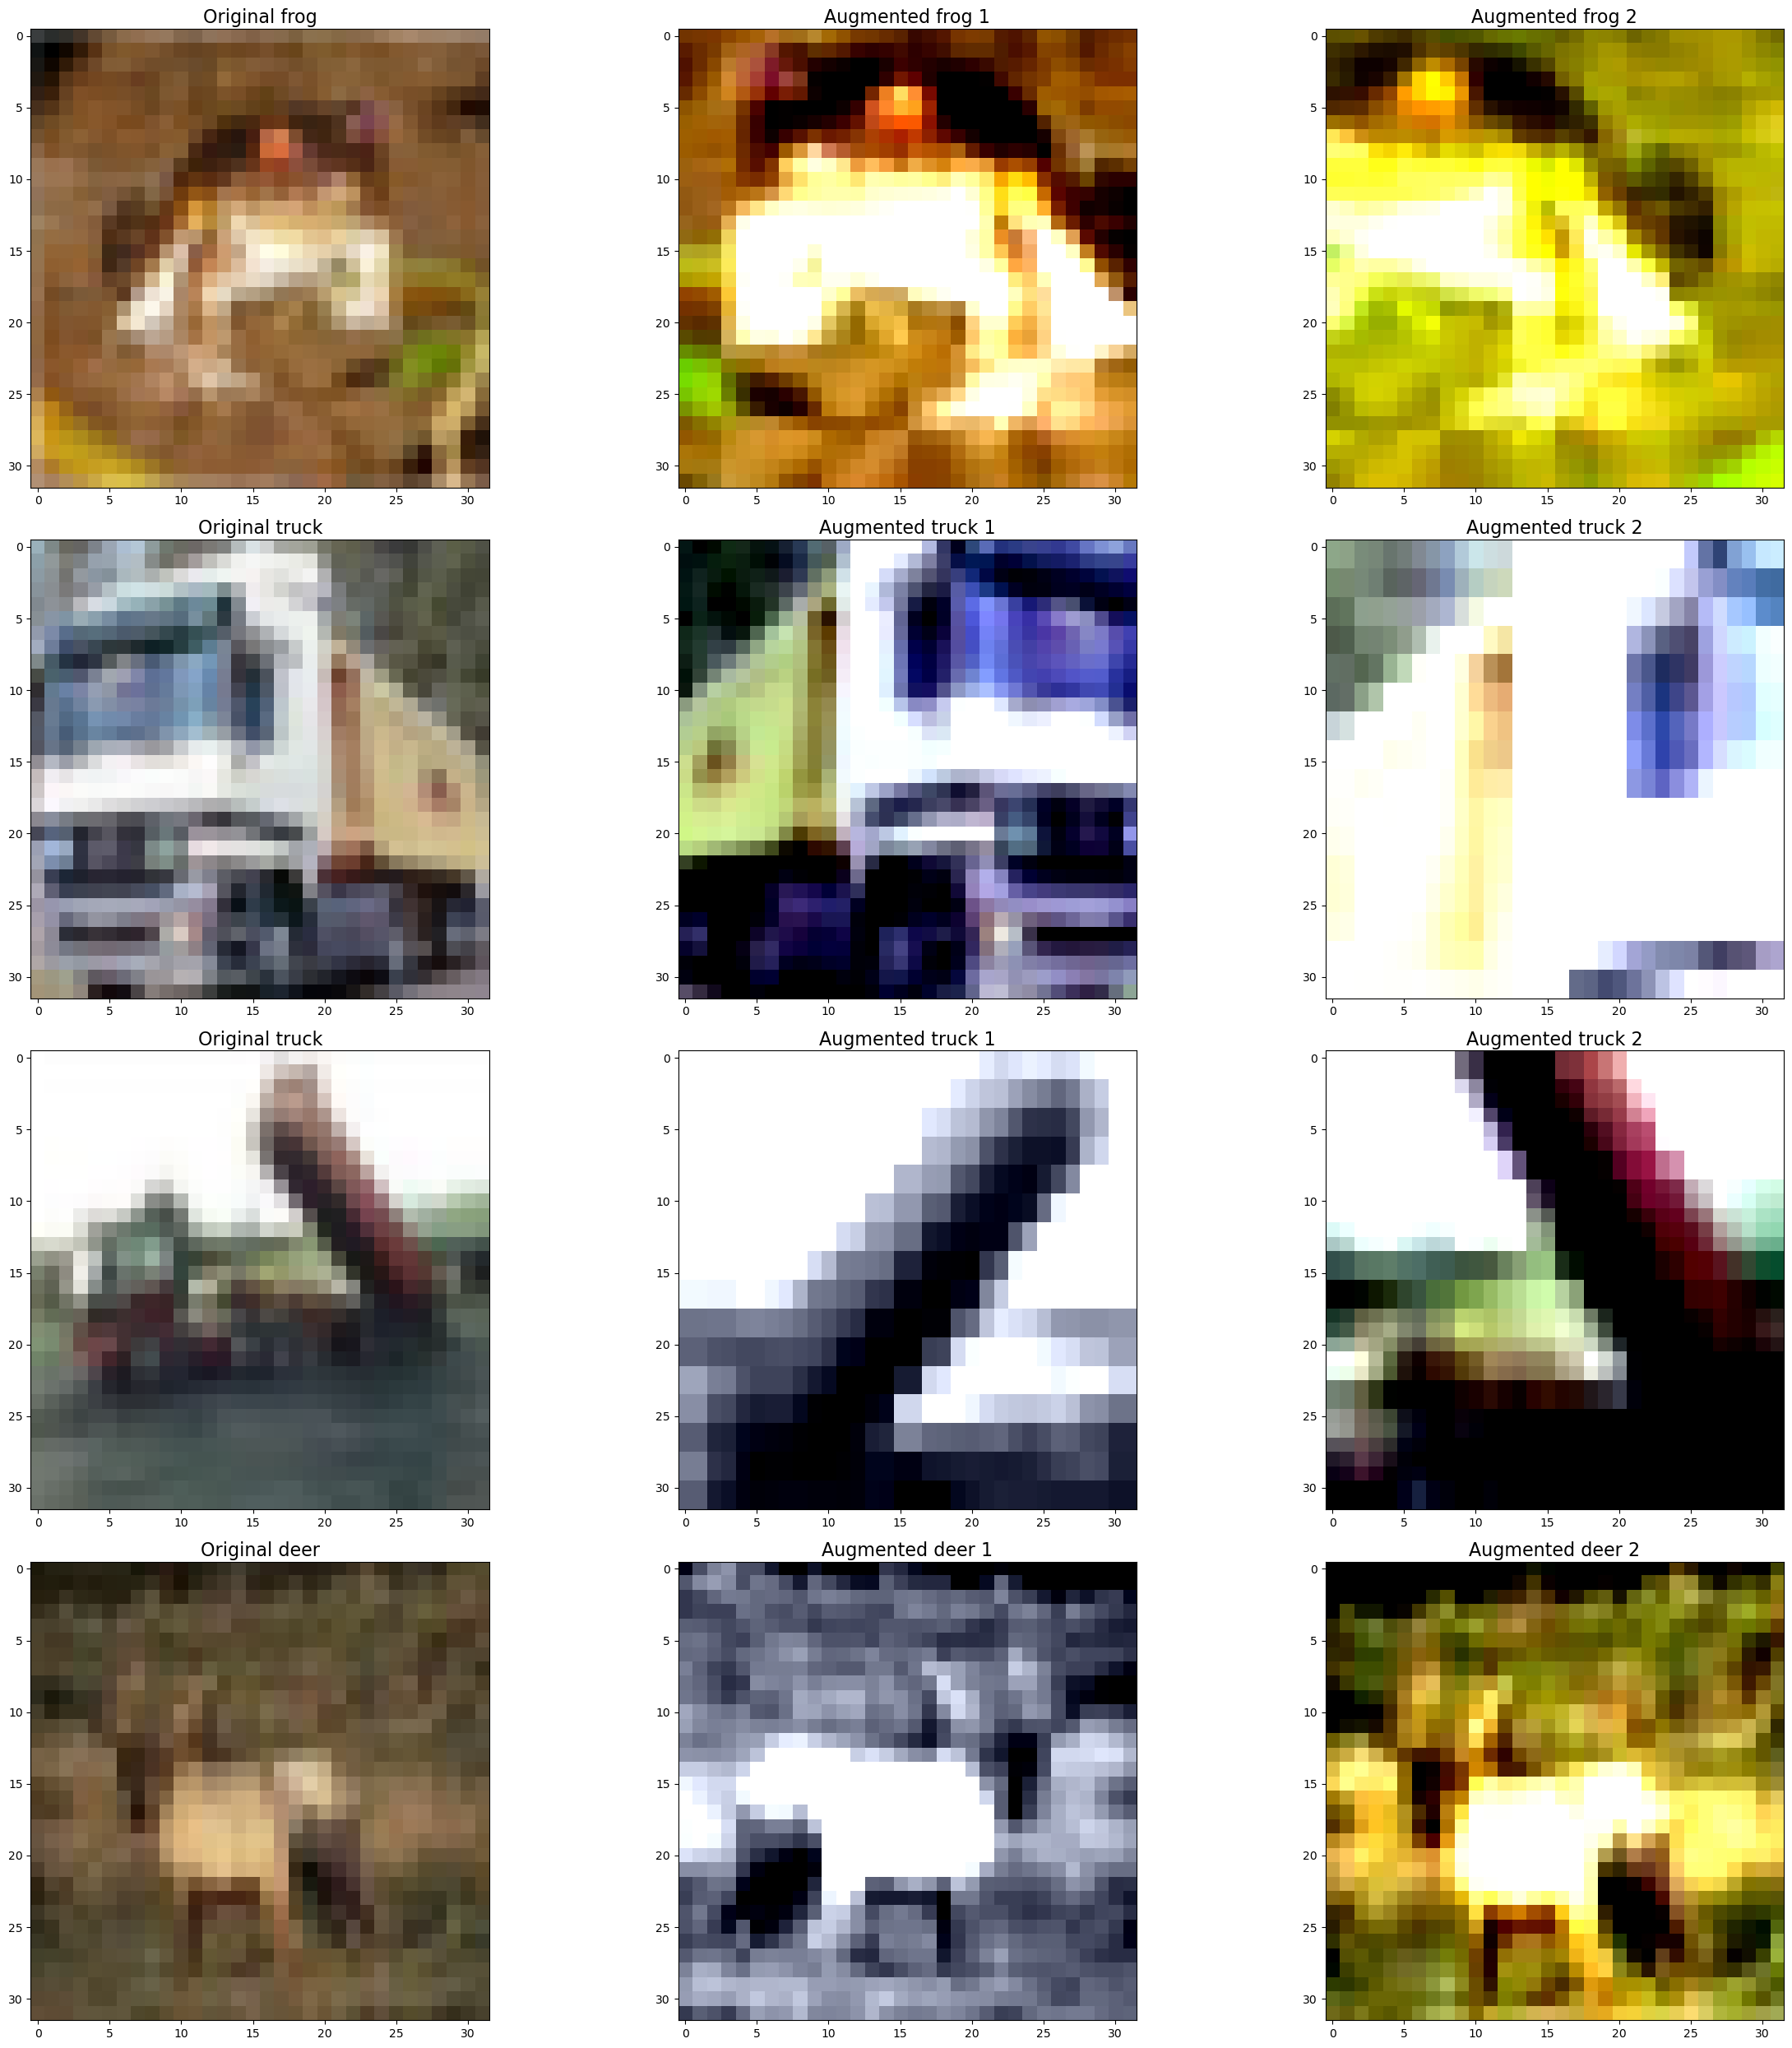

In [12]:
plot_imgs(imgs_orig, imgs_aug1, imgs_aug2, labels)